In [3]:
#the goals of this assignment include:
#1. write isolation forest algorithm from scratch
#2. apply the algorithm to a dataset
#3. evaluate the performance of the algorithm
#4. write a report on the results

#the sources for this assignment are as follows:
#1 assignment7.pdf, https://d2l.sdbor.edu/d2l/le/dropbox/1911312/1282003/DownloadAttachment?fid=48071356
#2 https://en.wikipedia.org/wiki/Isolation_forest
#3 https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf


#the structure of the code is as follows:
#1. import libraries
#2. Use howework framework to define data location
#3. define classes
#4. define functions
#5. run the code



In [4]:
#1. import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import os

In [5]:
homework_data_path = '\\..\\data\\'
homework_data_file = 'X_and_y.npz'

#check if data file exists
if not os.path.exists(file_path := os.getcwd() + homework_data_path + homework_data_file):
    print(f'{file_path} does not exist. Exiting.')
    exit()

report_folder = '\\report\\'
report_images = report_folder + 'resources\\images\\'

#check if the folder exists
if not os.path.exists(report_image_path := os.getcwd() + report_images):
    os.makedirs(os.getcwd() + report_images)
    
if not os.path.exists(os.getcwd() + report_images):
    print(f'{report_image_path} could not be created')
    exit()

print(f'Using {report_image_path} for report images.')

X_and_y = np.load(file_path)
print(f'{file_path} loaded successfully. Data shape is {X_and_y["X"].shape} and {X_and_y["y"].shape}.')
X_train, X_test, y_train, y_test = train_test_split(X_and_y['X'], X_and_y['y'], test_size=0.2, random_state=42)

Using h:\dev\git\csc730\assignment 7\report\resources\images\ for report images.
h:\dev\git\csc730\assignment 7\..\data\X_and_y.npz loaded successfully. Data shape is (6960, 784) and (6960,).


In [6]:
#defining the class for the isolation forest
class isolation_forest:
    def __init__(self, X, **kwargs):
        self.X = X
        self.root = None
        
        if X is None:
            raise ValueError('X cannot be None')
        
        self.subsample_size = None
        
        if 'subsample_size' in kwargs:
            self.subsample_size = kwargs['sample_size']
        
        if 'psi' in kwargs:
            self.subsample_size = kwargs['psi']
        
        if self.subsample_size == None:
            self.subsample_size = len(X)/16 if len(X) > 16 else 1
        
        self.n_trees = None
        if 'n_trees' in kwargs:
            self.n_trees = kwargs['n_trees']
            
        if 't' in kwargs:
            self.n_trees = kwargs['t']
        
        if self.n_trees == None:
            self.n_trees = min(len(X)/16 if len(X) > 16 else 1 ,256)
        
        self.height_limit = np.ceil(np.log2(self.subsample_size))        
        self.trees = []
        
        if 'auto_fit' in kwargs and kwargs['auto_fit']:
            self.fit()
        
        
    #algorithm #1
    def fit(self):
        #initialize forest
        self.trees = []
                
        for _ in range(self.n_trees):
            X_prime = self.X[np.random.choice(self.X, size=self.subsample_size)]
            self.trees.append(IsolationTree(X_prime, psi = self.subsample_size, t=0, auto_fit=True))
            
    @staticmethod
    def c(psi):
        if psi > 2:
            return 1 + (2 * np.log(psi - 1) + np.euler_gamma) - (2 * (psi - 1) / psi)
        if psi == 2:
            return 1        
        return 0
    #algorithm #3    
    def path_length(self, **kwargs):
        x = None
        
        if 'x' in kwargs:
            x = kwargs['x']
            
        if 'instance' in kwargs:
            x = kwargs['instance']
            
        if x == None:
            raise ValueError('x or instance must be provided')
        
        T = None        
        if 'T' in kwargs:
            T = kwargs['T']
            
        if 'tree' in kwargs:
            T = kwargs['tree']
            
        if T == None:
            raise ValueError('T or tree must be provided')
        
        e = None
        if 'e' in kwargs:
            e = kwargs['e'] 
            
        if 'current_path_length' in kwargs:
            e = kwargs['current_path_length']
            
        if e == None:
            raise ValueError('e or current_path_length must be provided')
            
        height_limit = None
        if 'height_limit' in kwargs:
            height_limit = kwargs['height_limit']
        
        if 'l' in kwargs:
            height_limit = kwargs['l']
            
        if height_limit == None:
            raise ValueError('height_limit or l must be provided')
            
        if T.type == 'external' or e >= height_limit:
            return e + self.c(T.X.shape[0])
        
        a = T.split_attribute
        if x[a] < T.split_value:
            return self.path_length(x=x, T=T.left, l = height_limit,  e=e+1)
        
        return self.path_length(x=x, T=T.right,l = height_limit, e=e+1)
    
    def predict(self, x, threshold):
        scores = self.anomaly_score(x)
        #1 is anomaly, 0 is nominal
        return np.array(np.where(scores > threshold,1,0))
    
    #based on equivalent binary search tree structure length. equation 1 in reference [3]
    def anomaly_score(self, x):
        scores = []     
        
        for index in x:
            path_length_list = [tree.path_length(x=index, e=0, l=tree.height_limit) for tree in self.trees]
            score = 2 ** (-np.mean(path_length_list) / self.c(len(x)))
            scores.append(score)
        return np.array(scores)
    
    
class isolation_tree_node:
    def __init__(self, **kwargs):
        # height, size, left, right, split_attribute (q), split_value (p)
        self.depth = None
        if 'height' in kwargs:
            self.depth = kwargs['depth']
            
        if self.depth == None:
            raise ValueError('depth must be provided')
            
        self.size = None
        if 'size' in kwargs:
            self.size = kwargs['size']
            
        if self.size == None:
            raise ValueError('size must be provided')
                
        self.left = None
        if 'left' in kwargs:
            self.left = kwargs['left']
            
        self.right = None
        if 'right' in kwargs:
            self.right = kwargs['right']
            
        self.split_attribute = None
        if 'split_attribute' in kwargs:
            self.split_attribute = kwargs['split_attribute']
            
        if 'q' in kwargs:
            self.split_attribute = kwargs['q']
            
        self.split_value = None
        if 'split_value' in kwargs:
            self.split_value = kwargs['split_value']
            
        if 'p' in kwargs:
            self.split_value = kwargs['p']
            
        self.type = 'internal'
        if 'type' in kwargs:
            self.type = kwargs['type']
    
#defining the class for the isolation tree
class isolation_tree:
    def __init__(self, x, **kwargs):
        self.x = x
        self.root = None
                
        self.height_limit = None        
        if 'height_limit' in kwargs:
            self.height_limit = kwargs['height_limit']
            
        if 'l' in kwargs:
            self.height_limit = kwargs['l']
            
        if self.height_limit == None:
            raise ValueError('height_limit or l must be provided')
        
        self.height = None
        if 'height' in kwargs:
            self.height = kwargs['height']
            
        if 'e' in kwargs:
            self.height = kwargs['e']
            
        if self.height == None:
            raise ValueError('height or e must be provided')
            
        self.root = self._split(x, 0)

    #algorithm #2
    def _split(self, x, height):
        #if X can not be divided then
        if self.height >= self.height_limit or len(x) <= 1:                        
            return isolation_tree_node(height=height, size=len(x), type='external')
        
        #else        
        self.split_attributes = x.shape[1]
        self.split_attribute = np.random.choice(self.split_attributes)
        self.split_value = np.random.uniform(min(X[:, self.split_attribute]), max(X[:, self.split_attribute]))
        left = x[x[:, self.split_attribute] < self.split_value]
        right = x[x[:, self.split_attribute] >= self.split_value]
        self.left = IsolationTree(left, e=self.height + 1, l=self.height_limit)
        self.right = IsolationTree(right, e=self.height + 1, l=self.height_limit)        

    
                

    

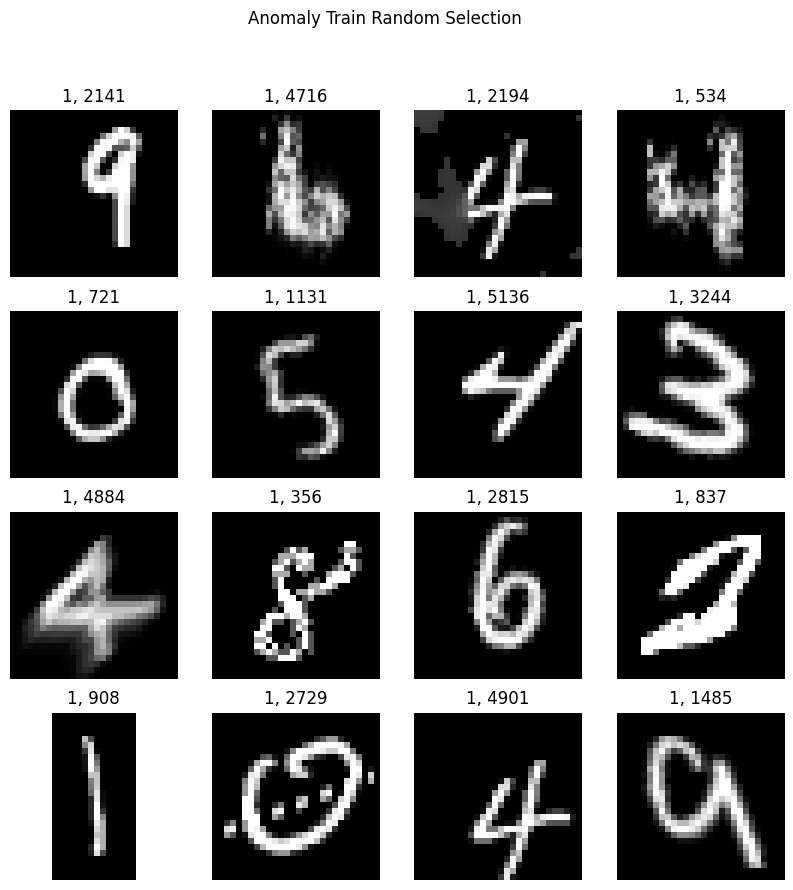

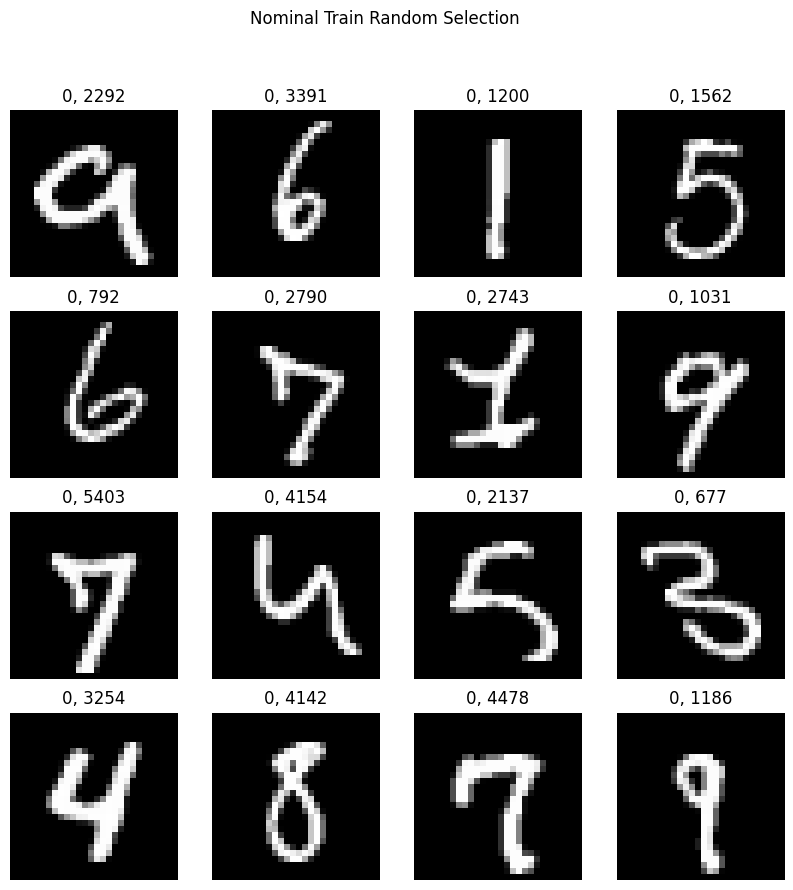

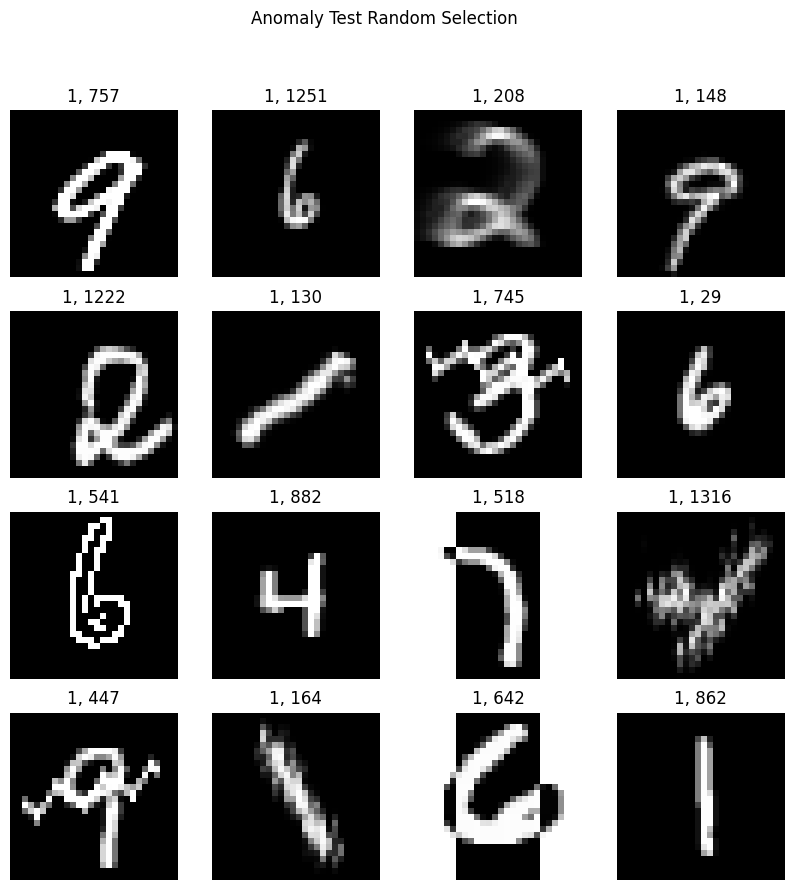

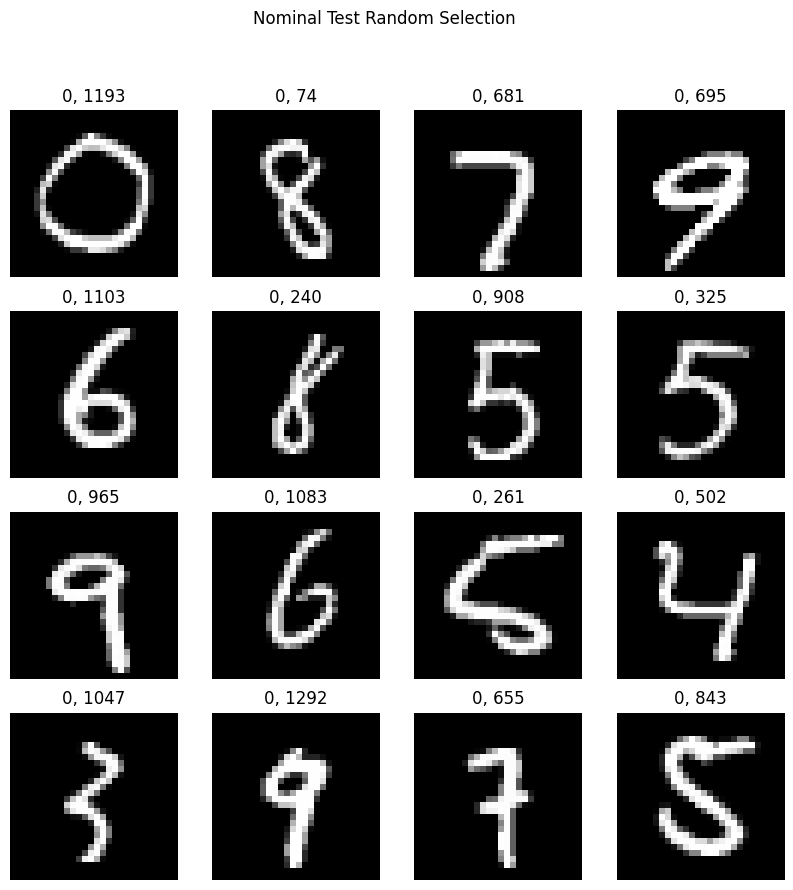

In [ ]:
#generate random selection of images
#subplot of x_test with y_test labels

#select 16 random index from X_train where y_train is 1, anomaly_train_indexes
#select 16 random index from X_train where y_train is 0, nominal_train_indexes
#select 16 random index from X_test where y_test is 1, anomaly_test_indexes
#select 16 random index from X_test where y_test is 0, nominal_test_indexes

anomaly_train_indexes = np.random.choice(np.where(y_train == 1)[0], 16, replace=False)
nominal_train_indexes = np.random.choice(np.where(y_train == 0)[0], 16, replace=False)
anomaly_test_indexes = np.random.choice(np.where(y_test == 1)[0], 16, replace=False)
nominal_test_indexes = np.random.choice(np.where(y_test == 0)[0], 16, replace=False)



#generate selection of images from 


fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = anomaly_train_indexes[i*4 + j]
        ax[i, j].imshow(X_train[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y_train[index]}, {index}')
        ax[i, j].axis('off')

plt.suptitle('Anomaly Train Random Selection')
plt.savefig(report_image_path + '_anomaly_train_random_selection.png')
plt.show()

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = nominal_train_indexes[i*4 + j]
        ax[i, j].imshow(X_train[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y_train[index]}, {index}')
        ax[i, j].axis('off')
plt.suptitle('Nominal Train Random Selection')        
plt.savefig(report_image_path + '_nominal_train_random_selection.png')
plt.show()

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = anomaly_test_indexes[i*4 + j]
        ax[i, j].imshow(X_test[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y_test[index]}, {index}')
        ax[i, j].axis('off')

plt.suptitle('Anomaly Test Random Selection')        
plt.savefig(report_image_path + '_anomaly_test_random_selection.png')
plt.show()

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = nominal_test_indexes[i*4 + j]
        ax[i, j].imshow(X_test[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y_test[index]}, {index}')
        ax[i, j].axis('off')
plt.suptitle('Nominal Test Random Selection')        
plt.savefig(report_image_path + '_nominal_test_random_selection.png')
plt.show()

Sklearn Isolation Forest created with 100 trees


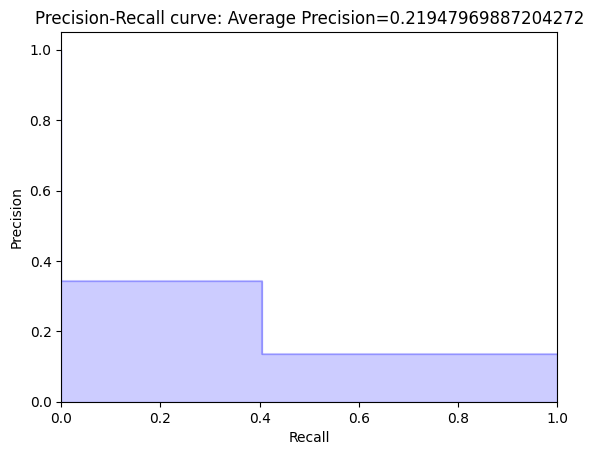

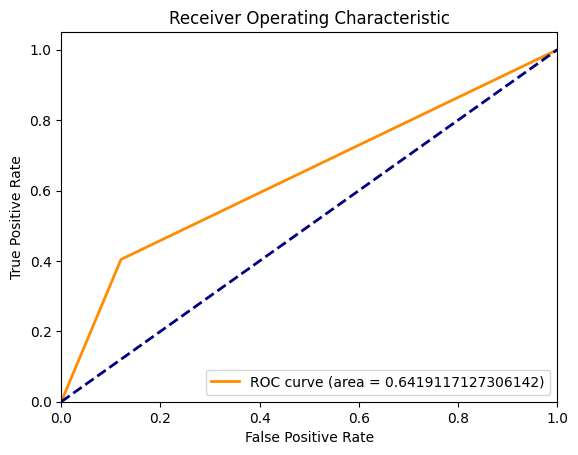

In [ ]:
#use iforest from sklearn
from sklearn.ensemble import IsolationForest as skIsolationForest
sk_iforest = skIsolationForest(max_samples=40, n_estimators=100, random_state=42)
sk_iforest.fit(X_train, y_train)
print(f'Sklearn Isolation Forest created with {len(sk_iforest.estimators_)} trees')

#generate precision-recall curve for the isolation forest
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

y_score = sk_iforest.predict(X_test)
y_score = np.where(y_score == 1, 0, 1)
#y_score = np.where(y_score == -1, 1, 0)
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: Average Precision={average_precision}')
plt.show()

#generate ROC curve for the isolation forest
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
 





In [68]:
class isolation_tree_node:
    def __init__(self, left=None, right=None, split_feature=None, split_value=None):
        self.left = left
        self.right = right
        self.split_feature = split_feature
        self.split_value = split_value

class isolation_tree:
    def __init__(self, max_height):
        self.max_height = max_height        
        self.root = None

    #algorithm #1
    def fit(self, x):
        self.root = self._split(x, 0)

    #algorithm #2
    def _split(self, x, height):
        #if X can not be divided then return external node
        if len(x) <= 1 or height >= self.max_height:
            return isolation_tree_node() #return exNode

        #else
        split_feature = np.random.randint(0, x.shape[1])
        split_value = np.random.uniform(x[:, split_feature].min(), x[:, split_feature].max())

        left_indices = x[:, split_feature] < split_value
        x_left, x_right = x[left_indices], x[~left_indices]

        return isolation_tree_node(
            left=self._split(x_left, height + 1),
            right=self._split(x_right, height + 1),
            split_feature=split_feature,
            split_value=split_value
        ) #return inNode

    #algorithm #3
    def path_length(self, x):
        node = self.root
        path_length = 0

        while node.left is not None and node.right is not None:            
            if x[node.split_feature] < node.split_value:
                node = node.left
            else:
                node = node.right
            path_length += 1

        return path_length

    @staticmethod
    def _c(n):
        if n > 2:
            return 2 * (np.log(n - 1) + np.euler_gamma) - (2 * (n - 1) / n)

        if n == 2:
            return 1
        
        return 0

class isolation_forest:
    ANOMALY = 1
    NOMINAL = 0
    def __init__(self, n_trees, sub_samples, max_height):
        self.n_trees = n_trees
        self.sub_samples = sub_samples
        self.max_height = max_height   
        self.trees = []
        

    def fit(self, x):
        for _ in range(self.n_trees):
            if self.sub_samples is None:
                sample_indices = np.arange(x.shape[0])
            else:
                sample_indices = np.random.choice(x.shape[0], size=self.sub_samples, replace=False)
                
            x_sample = x[sample_indices]

            tree = isolation_tree(self.max_height)
            tree.fit(x_sample)
            self.trees.append(tree)

    def anomaly_scores(self, x):
        scores = []
        for xi in x:
            path_lengths = [tree.path_length(xi) for tree in self.trees]
            score = 2 ** (-np.mean(path_lengths) / isolation_tree._c(len(x)))
            scores.append(score)
        return np.array(scores)

    def predict(self, x, threshold):
        scores = self.anomaly_scores(x)
        
        if threshold is None:
            raise ValueError('threshold must be provided')          
        
        return np.where(scores > threshold, self.ANOMALY, self.NOMINAL)

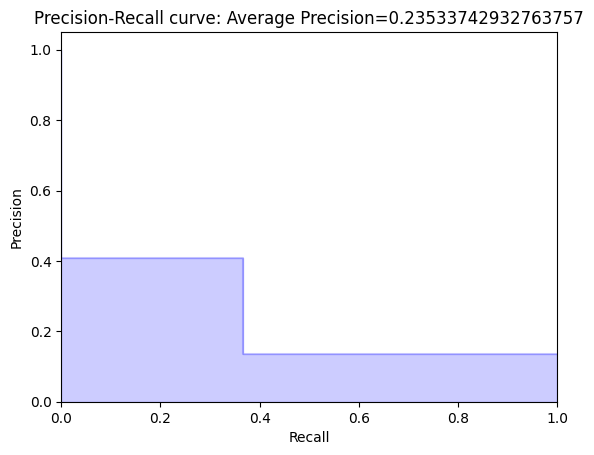

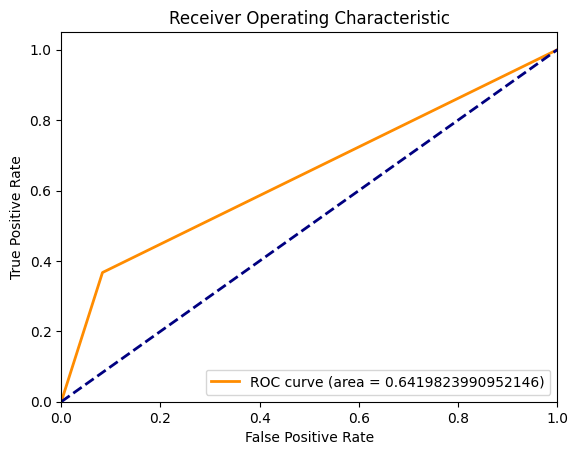

In [72]:

my_iforest = isolation_forest( n_trees=1000, sub_samples=64, max_height=50)
my_iforest.fit(X_train)
#print(f'Sklearn Isolation Forest created with {len(sm_iforest.estimators_)} trees')

#generate precision-recall curve for the isolation forest
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

y_score = my_iforest.predict(X_test, 0.5)

precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: Average Precision={average_precision}')
plt.show()

#generate ROC curve for the isolation forest
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
 
